# FORECAST AND OPTIMIZATION FOR RENEWABLE ENERGY SCHEDULING

### Background
One of the most important challenges to tackle climate change is the decarbonisation of energy production with the use of renewable energy sources such as wind and solar. A challenge here is that renewable energy cannot be produced on demand but the production depends literally on when the wind blows and when the sun shines, which is usually not when demand for electricity is highest. Storing energy is costly and normally associated with loss of energy. Thus, with having more and more renewable energy in the grid, it becomes increasingly important to forecast accurately both the energy demand and the energy production from renewables, to be able to produce power from on-demand-sources (e.g., gas plants) if needed, to shed loads and schedule demand to certain times where possible, and to optimally schedule energy storage solutions such as batteries. In particular, a nowadays common setup is a rooftop solar installation and a battery, together with certain demand flexibilities. Here, we need to forecast the electricity demand, the renewable energy production, and the wholesale electricity price, to be able to then optimally schedule the charging and discharging of the battery, and to schedule the schedulable parts of the demand (when to put the washing machine, when to use the pool pump, etc.). In this way, we can charge the battery with overproduction of solar energy, and use power from the battery instead of power from the grid when energy prices are highest, as well as schedule demand according to energy availability.

### Data description
The goal is to develop an optimal battery schedule and an optimal lecture schedule, based on predictions of future values of energy demand and production. In particular, in this project, we have the following data available. Energy consumption data recorded every 15 minutes from 6 buildings on the Monash Clayton campus, up to September 2020. Solar production data, again with 15 minutes of granularity, from 6 rooftop solar installations from the Clayton campus, also up to September 2020. Furthermore, weather data is available from the Australian Bureau of Meteorology and electricity price data is available from the Australian Energy Market Operator. The goal is now to optimally schedule a battery and timetabled activities (lectures) for the month of October 2020.


## Forecast

In [1]:
# from google.colab import drive 
# drive.mount('/content/drive/')

# %cd /content/drive/Othercomputers/My PC/Final project/Forecast-Code/

In [2]:
from datetime import datetime
from numpy import distutils
import distutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path
import gurobipy as gp
import time 

cd = r'C:\Users\Nmeso\OneDrive\Documents\Final project\Forecast-Code'
sys.path.append(cd)
project_dir= r'C:\Users\Nmeso\OneDrive\Documents\Final project' 

# cd = '/content/drive/Othercomputers/My PC/Final project/Forecast-Code'
# sys.path.append(cd)
# project_dir= '/content/drive/Othercomputers/My PC/Final project' #project_directory

from data_loader import *
from Utility_functions import *
plt.rcParams["figure.dpi"] = 100

### Convert Tsf to dataframe

In [3]:

# Example of usage

datapath = project_dir+'/Forecast-Data/phase_1_data.tsf'
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe(datapath)

### Process Weather Data

In [4]:

# Load Building and Solar data
df = pd.read_csv(project_dir+'\\Forecast-Data\\extracted_raw\\raw_Data_Series.csv', index_col=0, 
                 parse_dates=True)

## Load weather data, keep only relevant dates

weather_df = pd.read_csv(project_dir+'\\Forecast-Data\\ERA5_Weather_Data_Monash.csv', index_col=0, 
                 parse_dates=True)[['temperature (degC)', 'dewpoint_temperature (degC)',
                                   'wind_speed (m/s)', 'mean_sea_level_pressure (Pa)',
                                   'relative_humidity ((0-1))', 'surface_solar_radiation (W/m^2)',
                                   'surface_thermal_radiation (W/m^2)', 'total_cloud_cover (0-1)']]

# Check for NaNs
for c in weather_df.columns:
    print('NaNs: ', weather_df[c].isna().sum())

NaNs:  0
NaNs:  0
NaNs:  0
NaNs:  0
NaNs:  0
NaNs:  0
NaNs:  0
NaNs:  0


In [5]:
#%% Extend data to target dates
# Phase 1: Oct 2020 (2977 observations)
# Phase 2: Nov 2020
    
phase1_dates = pd.date_range(start = '2020-10-01', end = '2020-11-01', freq='15min')
phase2_dates = pd.date_range(start = '2020-11-01', end = '2020-12-01', freq='15min')

# Extend index to cover target dates
df = df.reindex(df.index.append(phase1_dates))

In [6]:
#%% Variables related to COVID, exams, etc. Mainly affect load forecasts

df['Break'] = 0
df['Break'][:'2020-03-01'] = np.nan
df['Break']['2020-04-10':'2020-04-17'] = 1
df['Break']['2020-06-15':'2020-09-19'] = 1

df['Semester'] = 0
df['Semester'][:'2020-03-01'] = np.nan
df['Semester']['2020-03-09':'2020-06-12'] = 1

df['Exams'] = 0
df['Exams'][:'2020-03-01'] = np.nan
df['Exams']['2020-06-22':'2020-07-10'] = 1

# Out-of-sample
df['Break']['2020-11-09':'2020-11-13'] = 1
df['Semester']['2020-08-03':'2020-11-06'] = 1
df['Exams']['2020-11-16':'2020-12-04'] = 1


C:\Users\Nmeso\AppData\Local\Temp/ipykernel_21324/3544663783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Break'][:'2020-03-01'] = np.nan
C:\Users\Nmeso\AppData\Local\Temp/ipykernel_21324/3544663783.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Semester'][:'2020-03-01'] = np.nan
C:\Users\Nmeso\AppData\Local\Temp/ipykernel_21324/3544663783.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Exams'][:'2020-03-01

In [7]:
#%% COVID-related variables

# Categorical variable for covid
df['COVID'] = 0
df['COVID']['2020-03-01':] = 1

# Monash Occupancy in % (needs check)
df['Monash_occupancy'] = 1
df['Monash_occupancy']['2020-06-20':'2020-07-19'] = 0.1
df['Monash_occupancy']['2020-08-02':'2020-09-13'] = 0.05
df['Monash_occupancy']['2020-09-13':'2020-10-18'] = 0.25
df['Monash_occupancy']['2020-10-18':] = 0.3


C:\Users\Nmeso\AppData\Local\Temp/ipykernel_21324/4221150232.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['COVID']['2020-03-01':] = 1
C:\Users\Nmeso\AppData\Local\Temp/ipykernel_21324/4221150232.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Monash_occupancy']['2020-06-20':'2020-07-19'] = 0.1


In [8]:
#%% Upscale weather data @ 15min, join all data in single dataframe, save output
weather_df = weather_df.resample('15min').interpolate('linear')
df = df.join(weather_df, how='outer')
df.to_csv(project_dir+'\\Forecast-Data\\extracted_raw\\aggr_Data_Series.csv')

<AxesSubplot:>

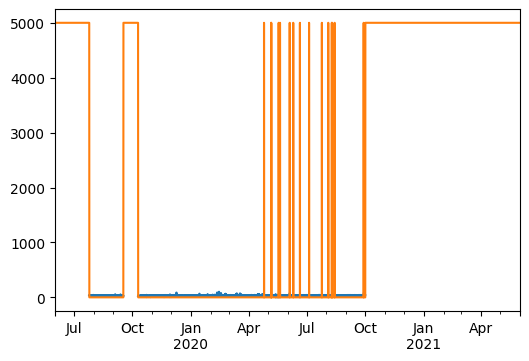

In [9]:
#%%%%%%%%%%%%%%%%%%%
# Check building data

b = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5','Building6']

df['Building6']['2019-06-01':].plot()

(5000*(df['Building6']['2019-06-01':].isna().astype(int))).plot()

In [10]:
#%%

s = ['Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5']

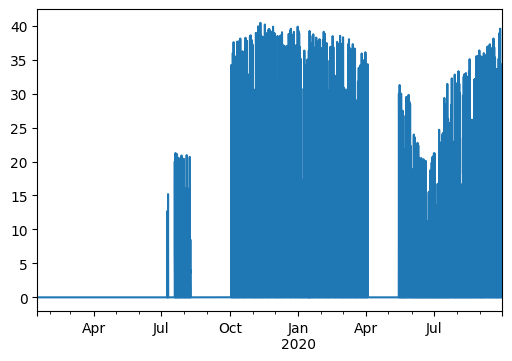

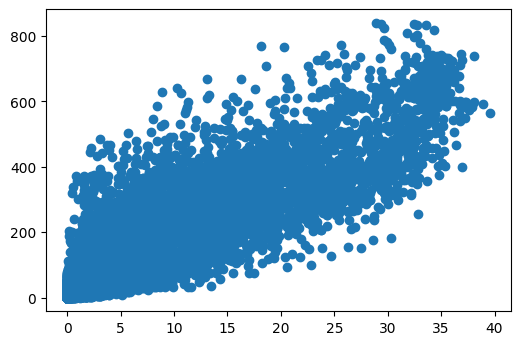

In [11]:
#%%
for s in ['Solar5']:
    mask = ~df[s].isna()

    df[s][mask].plot()
    plt.show()
    
    plt.scatter(df[s]['2020-06-01':], weather_df['surface_solar_radiation (W/m^2)']['2020-06-01':df.index[-1]])
    plt.show()#%%

<AxesSubplot:>

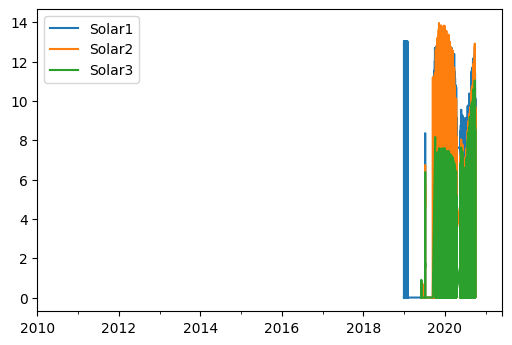

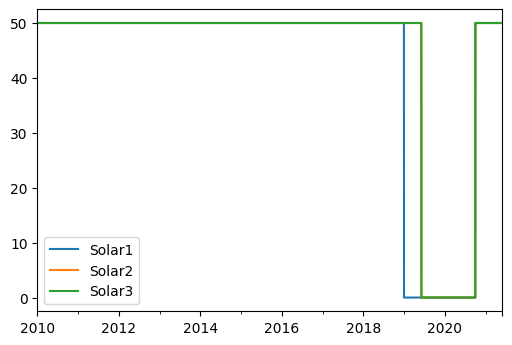

In [12]:
#%%
df[['Solar1', 'Solar2', 'Solar3']].plot()
(50*(df[['Solar1', 'Solar2', 'Solar3']].isna().astype(int))).plot()

##### New

Building0
(148810, 1)
Number of NaNs:  Building0    47404
dtype: int64


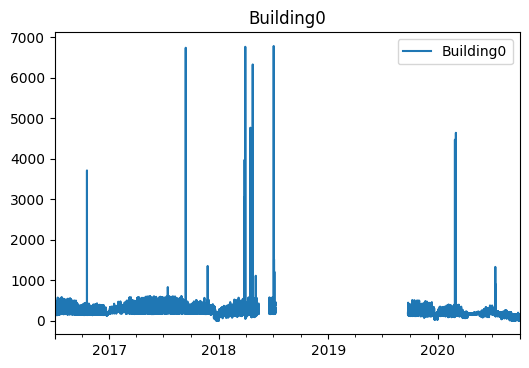

Building1
(60483, 1)
Number of NaNs:  Building1    88
dtype: int64


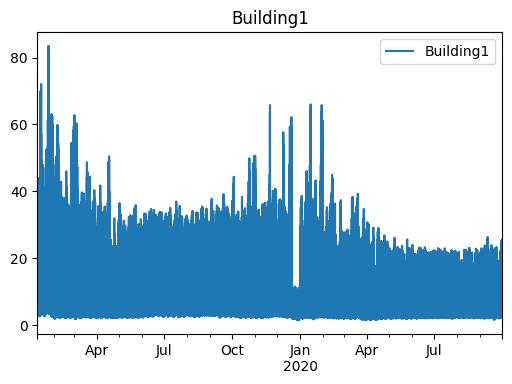

Building3
(160783, 1)
Number of NaNs:  Building3    561
dtype: int64


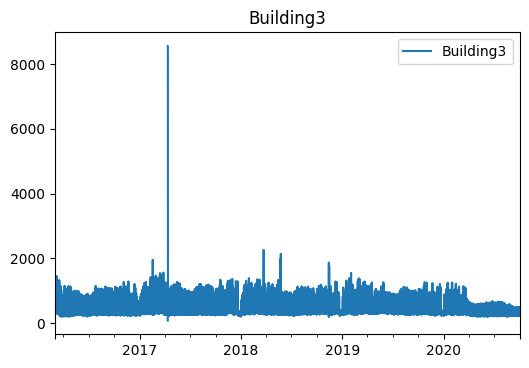

Building4
(43757, 1)
Number of NaNs:  Building4    17661
dtype: int64


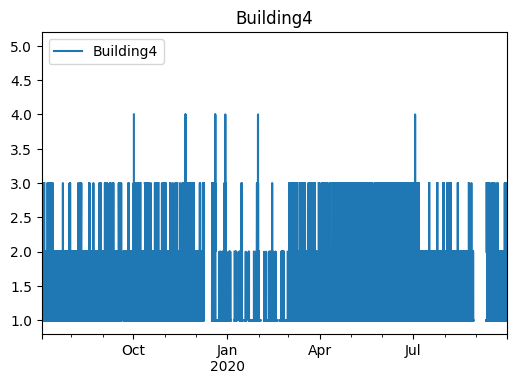

Building5
(41572, 1)
Number of NaNs:  Building5    29992
dtype: int64


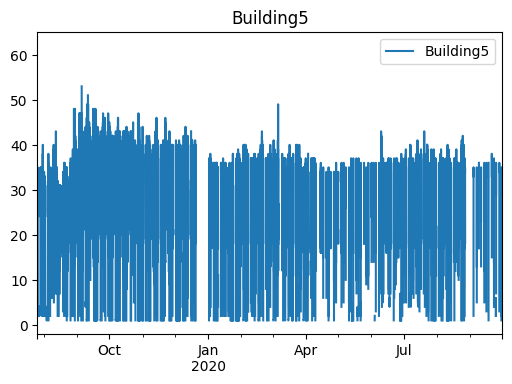

Building6
(41657, 1)
Number of NaNs:  Building6    2255
dtype: int64


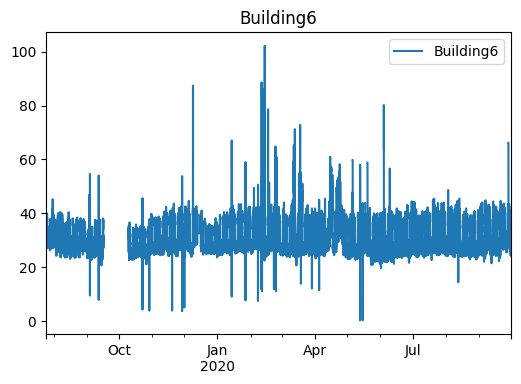

Solar0
(15208, 1)
Number of NaNs:  Solar0    0
dtype: int64


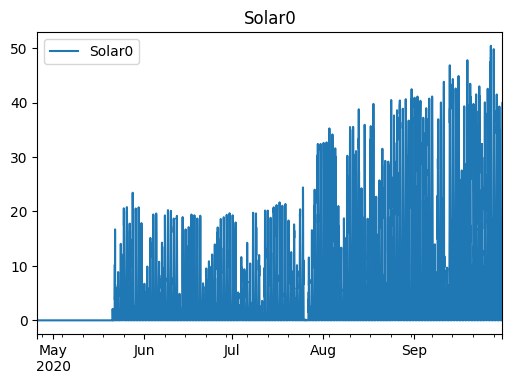

Solar1
(61388, 1)
Number of NaNs:  Solar1    0
dtype: int64


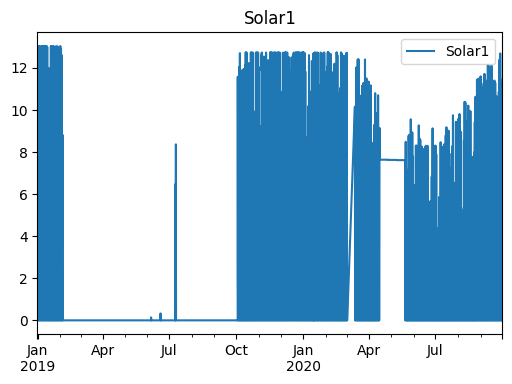

Solar2
(46408, 1)
Number of NaNs:  Solar2    0
dtype: int64


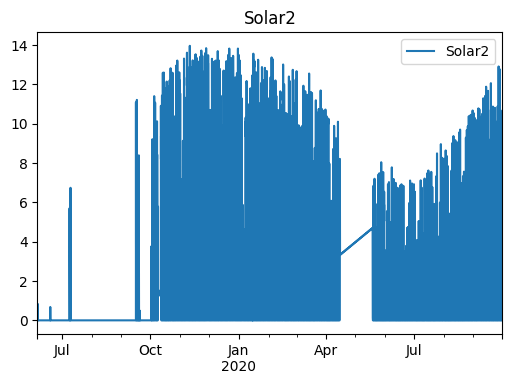

Solar3
(46408, 1)
Number of NaNs:  Solar3    0
dtype: int64


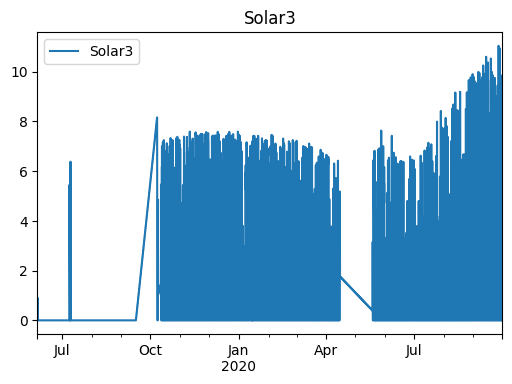

Solar4
(46408, 1)
Number of NaNs:  Solar4    0
dtype: int64


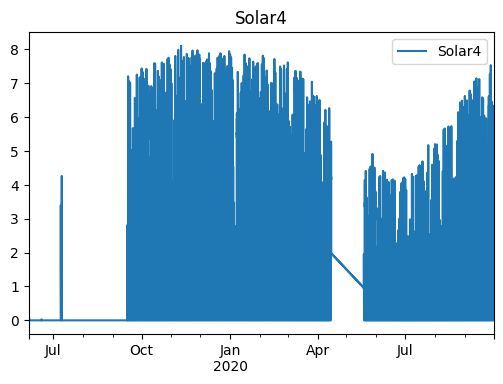

Solar5
(59948, 1)
Number of NaNs:  Solar5    0
dtype: int64


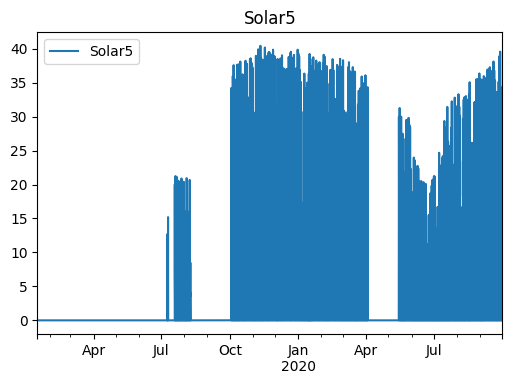

In [13]:
#Save output

var_names = loaded_data['series_name'].values
total_df = []

for var_ in var_names:
    print(var_)
    
    start_time = loaded_data[loaded_data['series_name']==var_]['start_timestamp'].values[0]
    temp_data = loaded_data[loaded_data['series_name']==var_]['series_value'].values[0]

    df = pd.DataFrame(data = np.array(temp_data).astype(np.float64),
                      index = pd.date_range(start = start_time, periods = len(temp_data), freq = '15min'), columns=[var_])

    print(df.shape)
    print('Number of NaNs: ', df.isna().sum())
    df.plot()
    plt.title(var_)
    plt.show()
    
    df.to_csv(project_dir+'/Forecast-Data/extracted_raw/'+var_+'.csv')
    
    total_df.append(df)
    

In [14]:
aggr_df = pd.concat(total_df, axis=1)

aggr_df.to_csv(project_dir+'\\Forecast-Data\\extracted_raw\\raw_Data_Series.csv')


<AxesSubplot:>

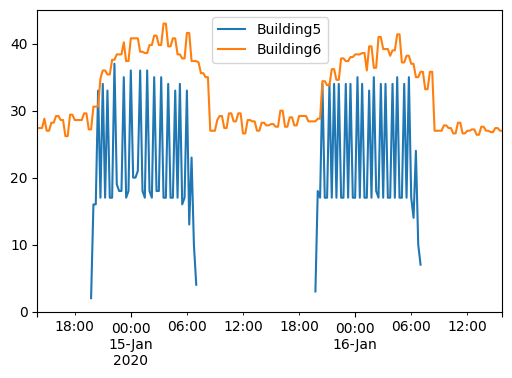

In [15]:
aggr_df[['Building5', 'Building6']][-25000:-24800].plot()

#### aDAPTIVE MODEL

In [16]:

#%%
# Load aggregated data
df = pd.read_csv(project_dir+'\\Forecast-Data\\extracted_raw\\aggr_Data_Series.csv', index_col=0, 
                 parse_dates=True)
#%%
# Timezones
df['UTC'] = df.index
df['UTC'] = df['UTC'].dt.tz_localize('UTC')

# AEDT: with daylight savings
# AEST: standard time, no daylight savings
df['AEDT'] = df['UTC'].dt.tz_convert('Australia/Melbourne')
df['AEST'] = df['UTC'] + pd.Timedelta(hours=10)
local_time = True

if local_time == True:    
    df.index = df['AEST']
    print('Results in AEST')
else:
    df.index = df['UTC']
    print('Results in UTC')

Results in AEST


In [17]:
# Add categorical variables
df['Month'] = df.index.month.astype(str)
df['Day'] = df.index.weekday.astype(str)
df['Hour'] = df.index.hour.astype(str)
df['Minute'] = df.index.minute.astype(str)
df['Semester'] = df['Semester'].astype(str)
df['Break'] = df['Break'].astype(str)
df['Exams'] = df['Exams'].astype(str)
df['COVID'] = df['COVID'].astype(str)
df['solar_ind'] = np.ones(len(df))
df['solar_ind'][df['surface_solar_radiation (W/m^2)']==0] = 0
df['solar_ind'] = df['solar_ind'].astype(int).astype(str)


C:\Users\Nmeso\AppData\Local\Temp/ipykernel_21324/2534263365.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_ind'][df['surface_solar_radiation (W/m^2)']==0] = 0


In [18]:
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [19]:
#%%

phase1_dates = pd.date_range(start = '2020-10-01', end = '2020-11-01', freq='15min')[:-1]

targets = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
       'Building6', 'Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5']
Forecasts = pd.DataFrame(data=[], columns = targets)   

test_start = '2020-10-01'
test_end = '2020-10-31'

quantiles = np.arange(.01, 1, .01)
#%% Solar Forecasts
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.feature_selection import mutual_info_regression

scaler = StandardScaler()

solar_plants = ['Solar0', 'Solar2', 'Solar1', 'Solar3', 'Solar4', 'Solar5']

pred_variables = ['temperature (degC)', 'dewpoint_temperature (degC)', 'wind_speed (m/s)',
   'mean_sea_level_pressure (Pa)', 'relative_humidity ((0-1))',
   'surface_solar_radiation (W/m^2)', 'surface_thermal_radiation (W/m^2)',
   'total_cloud_cover (0-1)', 'Day', 'Hour', 'Minute', 'solar_ind']

categorical_feat = [c for c in pred_variables if df[c].dtype=='O']
numeric_feat = [c for c in pred_variables if (df[c].dtype=='float64') or (df[c].dtype=='int')]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_feat),
    ('cat', categorical_transformer, categorical_feat)])

Solar0
LR with SGD:
 (0.7648041300221128, 4.0340873382767, 2.3447974269791922)
Gradient boosting:
 (0.6670963182705447, 2.5213514712432255, 1.3088852688955503)
Random Forest:
 (0.14165317667526842, 2.1431441372869737, 1.040833750000003)
Ridge Regression:
 (1.5128949711012827, 3.1012875965777047, 1.8147380652630034)
Average-Ensemble:
 (0.7322143078468032, 2.8820937330459264, 1.6051058886138485)


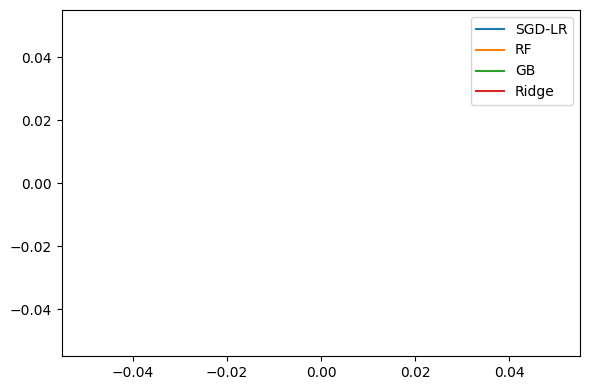

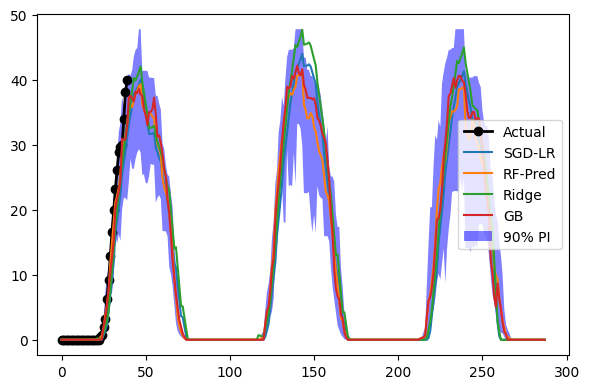

Solar2
LR with SGD:
 (inf, 0.7015609353308788, 0.3913437065341924)
Gradient boosting:
 (inf, 0.3708452745686349, 0.17177976079368373)
Random Forest:
 (inf, 0.3890217250520854, 0.16738625000000001)
Ridge Regression:
 (inf, 0.5065611020619225, 0.2877529986232812)
Average-Ensemble:
 (inf, 0.4681843208560101, 0.24741427007891764)


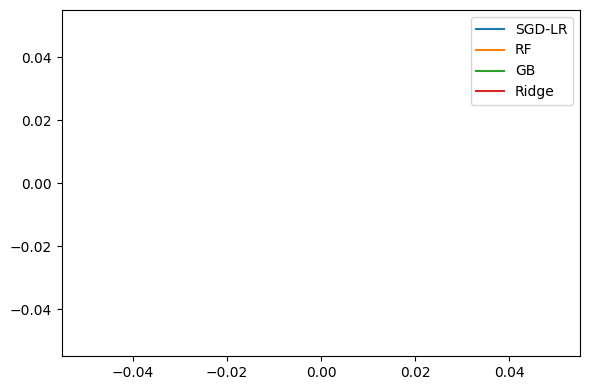

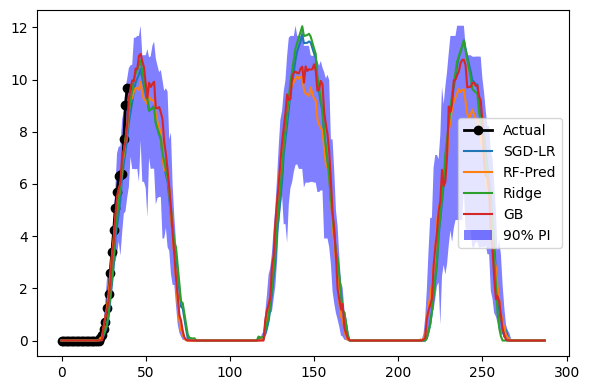

Solar1
LR with SGD:
 (inf, 0.7544399486947736, 0.4191271055489999)
Gradient boosting:
 (inf, 0.2791864825132297, 0.11902260862460896)
Random Forest:
 (inf, 0.3709552785545725, 0.1587937500000003)
Ridge Regression:
 (inf, 0.4598819922151897, 0.25832372883917853)
Average-Ensemble:
 (inf, 0.40706216776088333, 0.20578851747032728)


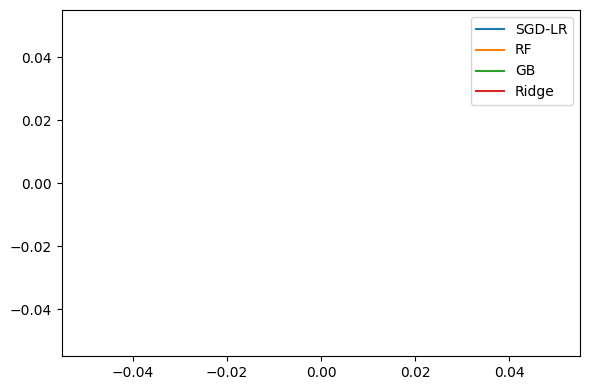

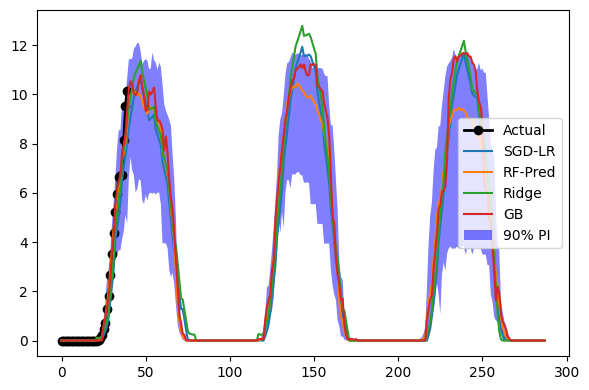

Solar3
LR with SGD:
 (0.33406410998601926, 0.4602746809369419, 0.24720906687903504)
Gradient boosting:
 (inf, 0.25029164985165353, 0.11246250243774211)
Random Forest:
 (inf, 0.25990562566054615, 0.11983749999999971)
Ridge Regression:
 (0.24948970110107482, 0.2883807858570844, 0.15213405706111355)
Average-Ensemble:
 (inf, 0.27216414125665894, 0.1157448829134586)


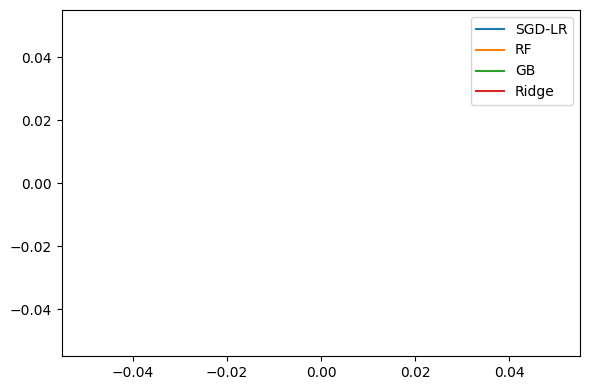

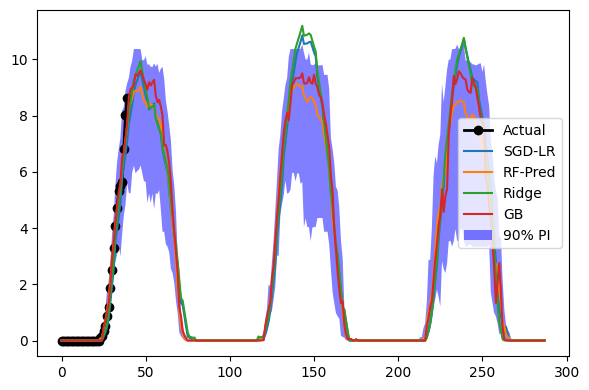

Solar4
LR with SGD:
 (inf, 0.7257376846743414, 0.4134312172892809)
Gradient boosting:
 (inf, 0.3687724364523297, 0.19025006029031394)
Random Forest:
 (inf, 0.3782899446026825, 0.17553375000000043)
Ridge Regression:
 (inf, 0.5610081820054578, 0.3182992565975017)
Average-Ensemble:
 (inf, 0.4960355394739366, 0.27000484095591687)


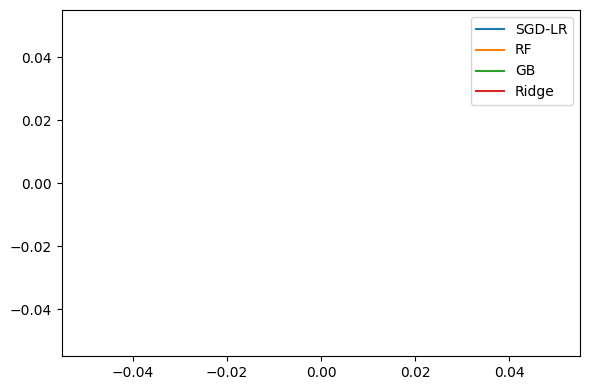

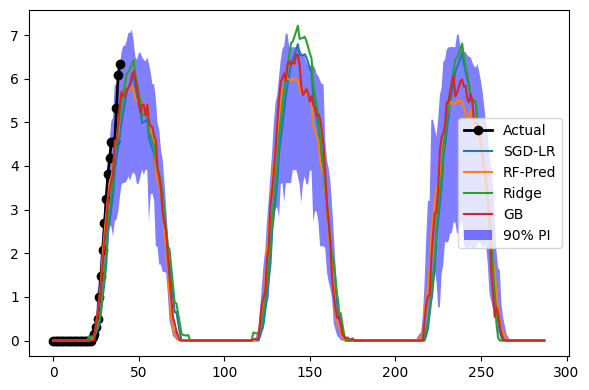

Solar5
LR with SGD:
 (4.14938434602014, 3.2715660023040734, 1.868941334442885)
Gradient boosting:
 (0.30693162782648187, 1.1779210163199063, 0.6002591538722506)
Random Forest:
 (inf, 1.3894479381214768, 0.6405250000000036)
Ridge Regression:
 (3.4206150602741334, 2.1565523897948715, 1.2241948189264171)
Average-Ensemble:
 (inf, 1.8640559848604656, 1.016521954090221)


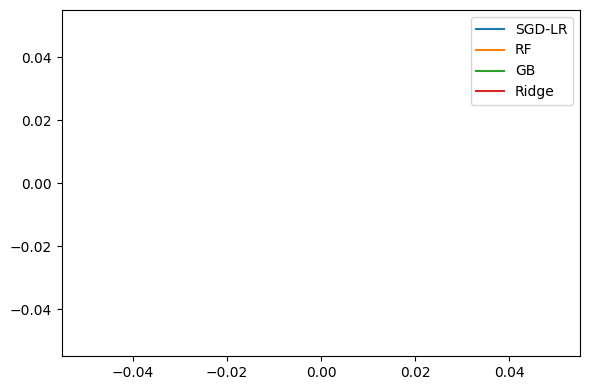

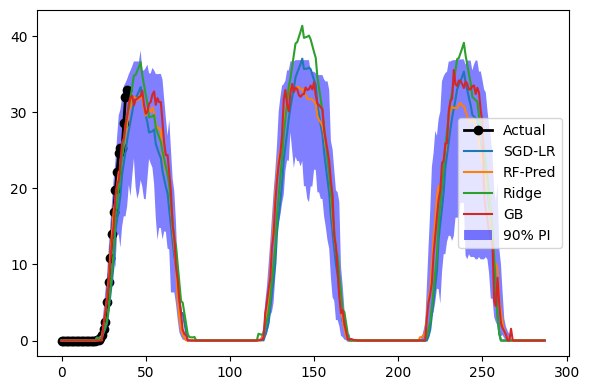

In [20]:
#%%
for sp in solar_plants:
    print(sp)
    # Exogenous Predictors
    
    # Historical Lags cannot be used (forecast one month ahead)
    # dates for start, split, end
    train_start = '2020-06-01'
    train_end = '2020-09-30'
        
    trainX = df[pred_variables][train_start:train_end]
    testX = df[pred_variables][test_start:test_end]

    sc_trainX = scaler.fit_transform(df[pred_variables][train_start:train_end])
    sc_testX = scaler.transform(df[pred_variables][test_start:test_end])
    
    prepr_trainX = preprocessor.fit_transform(trainX)
    prepr_testX = preprocessor.transform(testX)
    
    trainY = df[sp][train_start:train_end]
    testY = df[sp][test_start:test_end]
    
    sgd = SGDRegressor(eta0 = 0.001, penalty='l2', 
                       shuffle = False, learning_rate= 'constant')
    sgd.fit(prepr_trainX, trainY)
    
    # Batch updates
    sgd_pred =np.zeros(len(testY))
    for t in range(0, len(testX), 24):
        # Forecast
        sgd_pred[t:(t+1)*24] = sgd.predict(prepr_testX[t:(t+1)*24])
        # Update coefficients
        #sgd.partial_fit(testX[t:(t+1)*24], testY[t:(t+1)*24])
        
    sgd_pred[sgd_pred<0] = 0
    sgd_pred[testX['solar_ind']=='0'] = 0
    
    print('LR with SGD:\n', eval_point_pred(sgd_pred, testY))

    gb = GradientBoostingRegressor(loss='ls', learning_rate=0.01, n_estimators = 1000,
                                   criterion='friedman_mse', min_samples_leaf = 5, max_depth = 6, 
                                   n_iter_no_change = 30, validation_fraction=0.1)
    
    gb.fit(trainX.values, trainY.values)
    gb_pred = gb.predict(testX)
    gb_pred[gb_pred<0] = 0
    gb_pred[testX['solar_ind']=='0'] = 0

    print('Gradient boosting:\n', eval_point_pred(gb_pred, testY))
    
    #train model
    rf_model = ExtraTreesRegressor(n_estimators = 200, )
    rf_model.fit(trainX, trainY)
    rf_pred = rf_model.predict(testX)
    
    # generate probabilistic (quantile forecasts)    
    ensemble_for = np.array([rf_model.estimators_[tree].predict(testX).reshape(-1) \
        for tree in range(len(rf_model.estimators_))]).T

    Prob_predictions = np.quantile(ensemble_for, quantiles, axis = 1).T

    print('Random Forest:\n', eval_point_pred(rf_pred, testY))
    
    #train model
    pipeline =  Pipeline([('pre-processing', preprocessor), ('ridge', Ridge(alpha = 0.1))])
    pipeline.fit(trainX, trainY)
    lr_pred = pipeline.predict(testX)
    lr_pred[lr_pred<0] = 0
    lr_pred[testX['solar_ind']=='0'] = 0
    print('Ridge Regression:\n', eval_point_pred(lr_pred, testY))
    
    ave_pred = (rf_pred + gb_pred + lr_pred +sgd_pred)/4
    print('Average-Ensemble:\n', eval_point_pred(ave_pred, testY))
    
    plt.plot(np.abs(testY.values - sgd_pred).reshape(-1,24).mean(axis=0), label='SGD-LR')
    plt.plot(np.abs(testY.values - rf_pred).reshape(-1,24).mean(axis=0), label='RF')
    plt.plot(np.abs(testY.values - gb_pred).reshape(-1,24).mean(axis=0), label='GB')
    plt.plot(np.abs(testY.values - lr_pred).reshape(-1,24).mean(axis=0), label='Ridge')
    plt.legend()
    plt.tight_layout()
    plt.show()

    n = 3*96
    plt.plot(testY.values[:n], '-o', label='Actual', color = 'black', linewidth=2)
    plt.plot(sgd_pred[:n], label='SGD-LR')
    plt.plot(rf_pred[:n], label='RF-Pred')
    plt.plot(lr_pred[:n], label='Ridge')
    plt.plot(gb_pred[:n], label='GB')
    plt.fill_between( range(n),  Prob_predictions[:n,4], Prob_predictions[:n,-4], facecolor='blue', alpha = 0.5, label = '90% PI' )
    plt.legend()
    plt.tight_layout()
    plt.show()

    Forecasts[sp] = ave_pred

In [21]:
#%%

from sklearn.pipeline import Pipeline

buildings = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
       'Building6']

pred_variables = ['temperature (degC)', 'dewpoint_temperature (degC)', 'wind_speed (m/s)',
   'mean_sea_level_pressure (Pa)', 'relative_humidity ((0-1))',
   'surface_solar_radiation (W/m^2)', 'surface_thermal_radiation (W/m^2)',
   'total_cloud_cover (0-1)', 'Month', 'Day', 'Hour', 'Minute', 'COVID', 'Monash_occupancy']

categorical_feat = [c for c in pred_variables if df[c].dtype=='O']
numeric_feat = [c for c in pred_variables if (df[c].dtype=='float64') or (df[c].dtype=='int')]

categorical_feat_ind = [pred_variables.index(c) for c in pred_variables if df[c].dtype=='O']
numeric_feat_ind = [pred_variables.index(c) for c in pred_variables if (df[c].dtype=='float64') or (df[c].dtype=='int')]

Building0
LR with SGD:
 (0.3541832928548852, 38.455911329099266, 24.705855447937658)
Random Forest:
 (0.0843378140931809, 9.328846250340922, 6.379774999999995)
Ridge Regression:
 (0.45597787329554346, 53.09356067802333, 46.406650740187274)


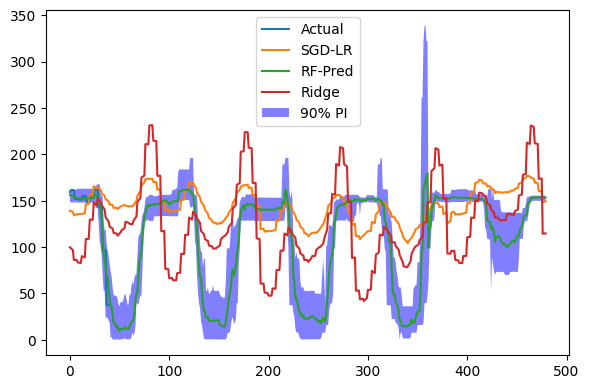

Building1
LR with SGD:
 (0.19898796720927361, 2.69305693250972, 2.1001227973330665)
Random Forest:
 (0.11862785777186877, 2.07346355918063, 1.4607124999999994)
Ridge Regression:
 (0.24289709882355268, 2.7802578343929047, 2.3760081313788173)


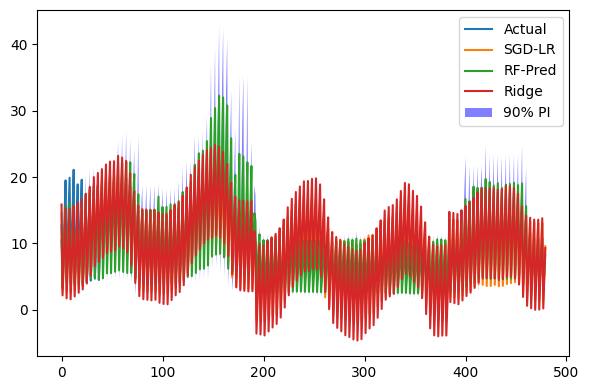

Building3
LR with SGD:
 (0.06827029667697779, 31.665244251471453, 21.26809509601493)
Random Forest:
 (0.0799690316786473, 37.91549346078724, 21.472375)
Ridge Regression:
 (0.15004115559529993, 84.31455792168632, 50.21767327998258)


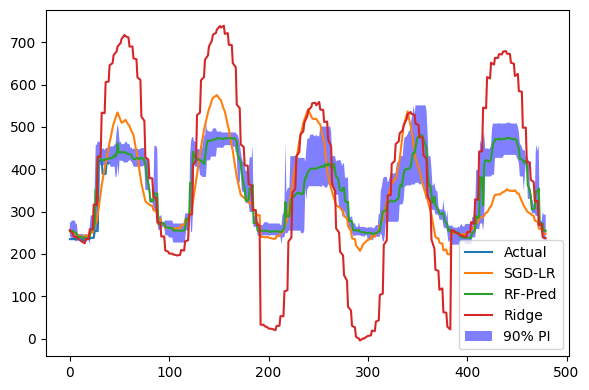

Building4
LR with SGD:
 (0.22834748023501836, 0.5939128835623517, 0.41538310885677815)
Random Forest:
 (0.33770000000000006, 0.48487833525535046, 0.46020000000000005)
Ridge Regression:
 (0.33960513887461047, 0.5025519606967855, 0.4745627733978502)


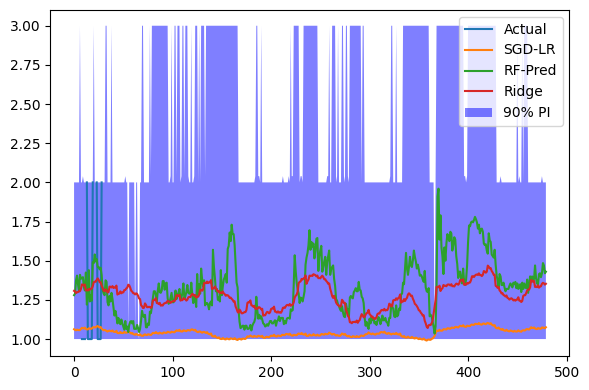

Building5


c:\Users\Nmeso\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Nmeso\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LR with SGD:
 (nan, nan, nan)


c:\Users\Nmeso\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Nmeso\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Nmeso\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Nmeso\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Random Forest:
 (nan, nan, nan)
Ridge Regression:
 (nan, nan, nan)


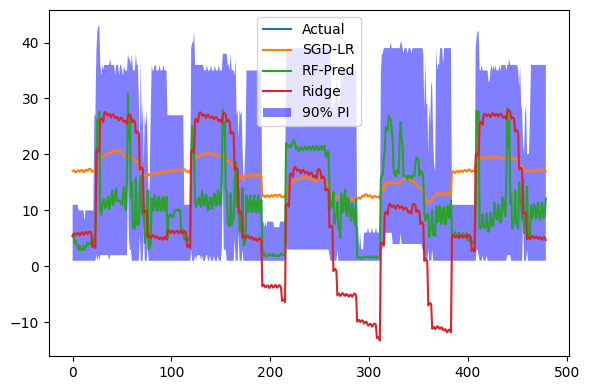

Building6
LR with SGD:
 (0.07799316569097473, 3.259704202222189, 2.5249832389209894)
Random Forest:
 (0.046618229965275176, 1.7435723672965253, 1.3847499999999968)
Ridge Regression:
 (0.07748590763761135, 3.2853528018129188, 2.526335684035277)


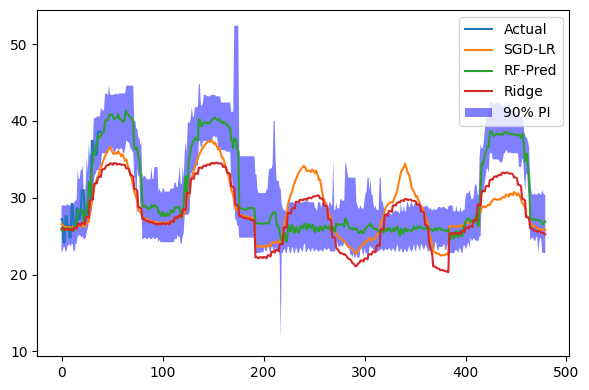

In [22]:
#%%
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_feat),
    ('cat', categorical_transformer, categorical_feat)])


for build in buildings:
    print(build)
    # Exogenous Predictors
    
    # Historical Lags cannot be used (forecast one month ahead)
    # dates for start, split, end
    train_end = '2020-09-30'
    
    trainX = df[pred_variables][:train_end]
    testX = df[pred_variables][test_start:test_end]

    trainY = df[build][:train_end].values
    testY = df[build][test_start:test_end].values

    # Remove NaNs
    #mask = ~trainY.isna()
    mask = ~np.isnan(trainY)
    trainX = trainX[mask]
    trainY = trainY[mask]
        
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_feat),
        ('cat', categorical_transformer, categorical_feat)])

    sc_trainX = scaler.fit_transform(trainX)
    sc_testX = scaler.transform(testX)

    prepr_trainX = preprocessor.fit_transform(trainX)
    prepr_testX = preprocessor.transform(testX)
    
    sgd = SGDRegressor(eta0 = 0.001, learning_rate = 'constant', penalty='l2', 
                       shuffle = False, loss='huber')
    sgd.fit(prepr_trainX, trainY)
    
    # Batch updates
    sgd_pred =np.zeros(len(testY))
    for t in range(0, len(testX), 24):
        # Forecast
        sgd_pred[t:(t+1)*24] = sgd.predict(prepr_testX[t:(t+1)*24])
        # Update coefficients
        #sgd.partial_fit(testX[t:(t+1)*24], testY[t:(t+1)*24])
            
    print('LR with SGD:\n', eval_point_pred(sgd_pred[~np.isnan(testY)], testY[~np.isnan(testY)]))

    '''
    gb = GradientBoostingRegressor(loss='huber', learning_rate=0.01, n_estimators = 1000,
                                   criterion='friedman_mse', min_samples_leaf = 2, max_depth = 6, 
                                  n_iter_no_change = 30, validation_fraction=0.1)
    
    gb.fit(trainX, trainY)
    gb_pred = gb.predict(testX)
    print('Gradient boosting:\n', eval_point_pred(gb_pred[~np.isnan(testY)], testY[~np.isnan(testY)]))
    '''
    #train model
    rf_model = RandomForestRegressor(n_estimators = 200, )
    rf_model.fit(trainX, trainY)
    rf_pred = rf_model.predict(testX)

    # generate probabilistic (quantile forecasts)    
    ensemble_for = np.array([rf_model.estimators_[tree].predict(testX).reshape(-1) \
        for tree in range(len(rf_model.estimators_))]).T

    Prob_predictions = np.quantile(ensemble_for, quantiles, axis = 1).T

    print('Random Forest:\n', eval_point_pred(rf_pred[~np.isnan(testY)], testY[~np.isnan(testY)]))
    
    #train model
    pipeline =  Pipeline([('pre-processing', preprocessor), ('ridge', Ridge(alpha = 0.1))])
    pipeline.fit(trainX, trainY)
    lr_pred = pipeline.predict(testX)
    print('Ridge Regression:\n', eval_point_pred(lr_pred[~np.isnan(testY)], testY[~np.isnan(testY)]))

    #ave_pred = (rf_pred+gb_pred+lr_pred+sgd_pred+lr_pred)/4
    #print('Average:\n', eval_point_pred(ave_pred[~np.isnan(testY)], testY[~np.isnan(testY)]))
    if build == 'Building0':
        rf_pred[rf_pred>3*rf_pred.mean()] = sgd_pred[rf_pred>3*rf_pred.mean()]
    
    Forecasts[build] = rf_pred

    n = 5*96
    plt.plot(testY[:n], label='Actual')
    plt.plot(sgd_pred[:n], label='SGD-LR')
    plt.plot(rf_pred[:n], label='RF-Pred')
    plt.plot(lr_pred[:n], label='Ridge')
    plt.fill_between( range(n),  Prob_predictions[:n,4], Prob_predictions[:n,-4], facecolor='blue', alpha = 0.5, label = '90% PI' )
    #plt.plot(gb_pred[:n], label='GB')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    if build == 'Building3':
        prob_df = pd.DataFrame(data=Prob_predictions, columns = ['Q'+str(q.round(2))  for q in quantiles] )
        prob_df.to_csv(project_dir+'\\Forecast-Results\\'+build+ '_probabilistic.csv', header=False)

In [23]:
#%%
output = pd.DataFrame(data=Forecasts.values.T, index=Forecasts.columns)

if local_time:
    output.to_csv(project_dir+'\\Forecast-Results\\ensemble_forecast_local.csv', header=False)
else:
    output.to_csv(project_dir+'\\Forecast-Results\\ensemble_forecast.csv', header=False)

### Optimization
